<h1 style="color:#1A5276;padding-bottom:0px;font-size:38px;text-align:center;">OJAN ENERGY</h1>
<h2 style="color:#1A5276;padding-bottom:0px;font-size:32px;text-align:center;"> Energy Efficiency in Facilities </h2>
<h3 style="color:#1A5276;padding-bottom:0px;font-size:32px;text-align:center;">Combining IoT and Machine Learning for Predictive Maintenance </h3>
<p style="color:#1A5276;padding-top:0px;position:relative;font-style:italic;font-size:20px;text-align:center;">


## Challenge Description

590M people, or about half of sub-Saharan Africans constituting more than 45% of African households remain unelectrified, according to a report published in June 2022 by the International Energy Agency. In research published in 2019, Energy for Growth, a think-tank, noted that 78% of African firms experienced power cuts in the past year, while 41% said that electricity was a major constraint. Many businesses and well-off households rely on generators. These have more total capacity than there is in sub-Saharan Africa’s installed renewables. Clean-energy technologies present a huge opportunity for the continent towards sustainable energy solutions. 

## About/Business Understanding

Ojan Energy is an Energy as a service (EaaS) company. We aim to provide energy-efficiency solutions to residential, commercial, and industrial facilities.
Our goal is to help facilities cut down their energy-related costs while increasing their overall electrical health and safety.

In this project we are developing an energy management system that will enable real time monitoring of energy consumption within commercial and industrial facilities. This will provide building owners and facility managers with a centralized visibility into the energy consumption patterns which can be analysed to increase efficiency and cut down their energy costs by 10-20%. It will also provide asset health data that will enable predictive maintenance through automated alerts to avoid future equipment breakdown again saving them on costs. Overall this will improve the facilities’ electrical health and safety. 

This notebook contains the predictive part of the project for one machine. A further visual of the final system after deployment can be seen in the [figma prototype](https://www.figma.com/proto/QpJJ4OQr0ApL1ooixlugsR/Ojan-Energy?type=design&node-id=158-7&t=et6yNNh4ssNhZtWE-1&scaling=min-zoom&page-id=0%3A1&starting-point-node-id=158%3A7&mode=design).

Our goal is to help facilities cut down their energy-related costs while increasing their overall electrical health and safety.energy efficiency and predictive maintenance company is a specialized organization that focuses on optimizing energy consumption and enhancing the maintenance processes of various systems and equipment.  

## Background: problem description and approach

**Problem**

1. High energy consumption within facilites resulting to high operations costs.
2. Lack of visibility in asset health leading to unpredicted equipment breakdown.
3. Electrical damages caused by low power factors or current imbalances.

**Solution**

1. Cost Reduction- A centralized energy management system that provides visibility into the facilities' energy consumption patterns.
2. Predictive Maintenance- A real-time monitoring system that provides visibility into the asset health.
3. Improved Electrical Health and Safety- Automated alerts in cases of low power factors or current imbalances






## Data Understanding
 For this project we will make use of the [Microsoft Azure DataSet](https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_telemetry.csv) that can be used for predictive maintenance. The data consists of:
 
 * Machine conditions and usage: The operating conditions of a machine e.g. data collected from sensors.
 * Failure history: The failure history of a machine or component within the machine.
 * Maintenance history: The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.
 * Machine features: The features of a machine, e.g. engine size, make and model, location.

 
 **<font size="5"> Details</font>**
 
  The dataset consists of 5 csv files:
 
 
* **Telemetry Time Series Data (PdM_telemetry.csv)**: It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.

* **Error (PdM_errors.csv)**: These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

* **Maintenance (PdM_maint.csv)**: If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

* **Failures (PdM_failures.csv)**: Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

* **Metadata of Machines (PdM_Machines.csv)**: Model type & age of the Machines.


### Import Libraries



In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.losses as loss

matplotlib.style.use("Solarize_Light2")

%matplotlib inline

### Loading the data

In [7]:
#Read the data
telemetry_df = pd.read_csv("Data/PdM_telemetry.csv")
errors_df = pd.read_csv("Data/PdM_errors.csv")
maint_df = pd.read_csv("Data/PdM_maint.csv")
failures_df = pd.read_csv("Data/PdM_failures.csv")
machines_df = pd.read_csv("Data/PdM_machines.csv")

## Data Understanding
In order to get a better understanding of the data. We will check for null values, duplicates and general info on each of the datasets.

### Telemetry Data

In [8]:
# Display the first few rows.
telemetry_df.head(10)


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
5,2015-01-01 11:00:00,1,172.504839,430.323362,95.927042,35.655017
6,2015-01-01 12:00:00,1,156.556031,499.071623,111.755684,42.753920
7,2015-01-01 13:00:00,1,172.522781,409.624717,101.001083,35.482009
8,2015-01-01 14:00:00,1,175.324524,398.648781,110.624361,45.482287
9,2015-01-01 15:00:00,1,169.218423,460.850670,104.848230,39.901735


In [9]:
# Display the last few rows
telemetry_df.tail(10)

,datetime,machineID,volt,rotate,pressure,vibration
876090,2015-12-31 21:00:00,100,153.404574,552.012586,99.132955,37.666806
876091,2015-12-31 22:00:00,100,169.397346,546.144572,107.607030,38.695601
876092,2015-12-31 23:00:00,100,152.182033,414.011630,117.426340,43.966709
876093,2016-01-01 00:00:00,100,168.740039,439.484112,103.158233,47.289000
876094,2016-01-01 01:00:00,100,162.742669,481.253908,101.589735,44.382754
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259
876099,2016-01-01 06:00:00,100,171.336037,496.096870,79.095538,37.845245


The data was collected from 1st Jan 2015 to 1st Jan 2016

In [10]:
# Check general information about the data
telemetry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876100 non-null  object 
 1   machineID  876100 non-null  int64  
 2   volt       876100 non-null  float64
 3   rotate     876100 non-null  float64
 4   pressure   876100 non-null  float64
 5   vibration  876100 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.1+ MB


The telemetry data contains 6 columns, 876099 rows, 3 different datatypes. The date column is currently "non-null object" we will change the date type to "datetime" to ensure the dates are correctly understood.
We will also set the datetime column as the index as this will enable us to plot our time series data. 

We will create functions to check for null values and duplicates since we will repeat the process for each data set.
We will also create a function to convert the datetime columns to a datetime data type and set the date column as an index.

In [11]:
# telemetry_df["datetime"] = pd.to_datetime(telemetry_df["datetime"], format="%Y-%m-%d %H:%M:%S")
# telemetry_df.set_index('datetime', inplace=True)

In [12]:
def convert(df):
    
    """ Returns the dataset's datetime column as date datatype and sets it as the index"""
    
    df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
    df.set_index('datetime', inplace=True)
    return df

In [13]:
convert(telemetry_df)

,machineID,volt,rotate,pressure,vibration
datetime,,,,,
2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...
2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561


In [14]:
# Check for null values
def check_null(df):
    return df.isnull().sum()

In [15]:
check_null(telemetry_df)

machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64

In [16]:
# Check for duplicates
def duplicates(df):
    return df.duplicated().sum()

In [17]:
duplicates(telemetry_df)

0

In [18]:
# Check for the number of machines.
telemetry_df.machineID.nunique()

100

In [19]:
telemetry_df.machineID.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

In [20]:
# tables = [telemetry_df, maint_df, failures_df, errors_df]
# for df in tables:
#     df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
#     df.sort_values(["datetime", "machineID"], inplace=True, ignore_index=True)

###  Data Visualization

We will plot different graphs to get a better visual of the data and also to study the distribution.

In [21]:
#Plotting

def plot_ts(series, figsize=(20, 8), title=None, xlabel="", ylabel=""):
    """
    Plot Time Series data. The series object should have date or time as index.
    
    series: Series object to be plotted.
    """
    series.plot(figsize=figsize, subplots=True, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


In [22]:
# for column in telemetry_df:
#     print(column)

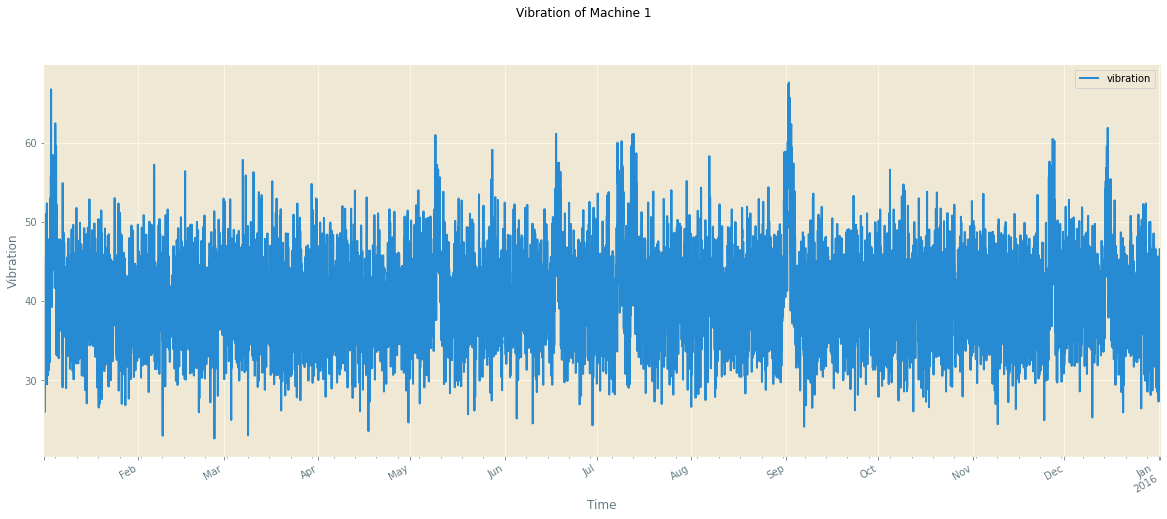

In [23]:
df_vib_machine_1 = telemetry_df[
    telemetry_df.machineID == 1][["vibration"]]
plot_ts(df_vib_machine_1, title="Vibration of Machine 1", xlabel="Time", ylabel="Vibration")

There appears to be some seasonality in the vibration of Machine 1

In [24]:
# telemetry_df.drop('machineID', axis=1)

In [25]:
# plot_ts(telemetry_df)

Overall, there appears to be seasonality in the different parameters. 

Checking for the distribution of the different features in the machines.

In [26]:
#Plotting histogram

def plot_hist(df, feature_name, kind='hist', bins=100, log=True):
    """
    Plot histogram.
    
    df: DataFrame
    feature_name: Name of the feature to be plotted.
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='hist', 
                                              bins=bins, 
                                              figsize=(15, 5), 
                                              title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='hist', 
                              bins=bins, 
                              figsize=(15, 5), 
                              title=f'Distribution of {feature_name}')
    plt.show()


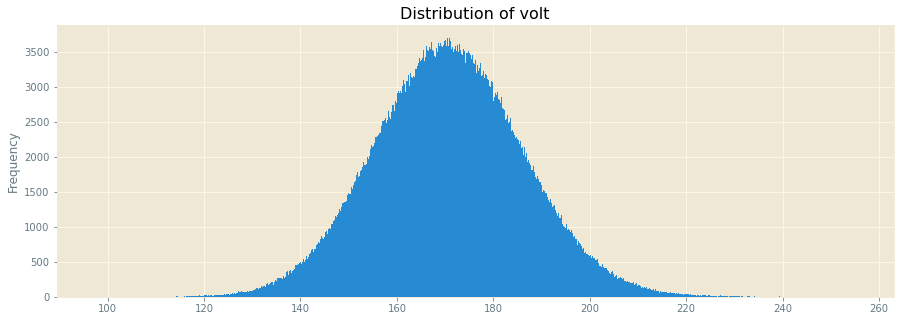

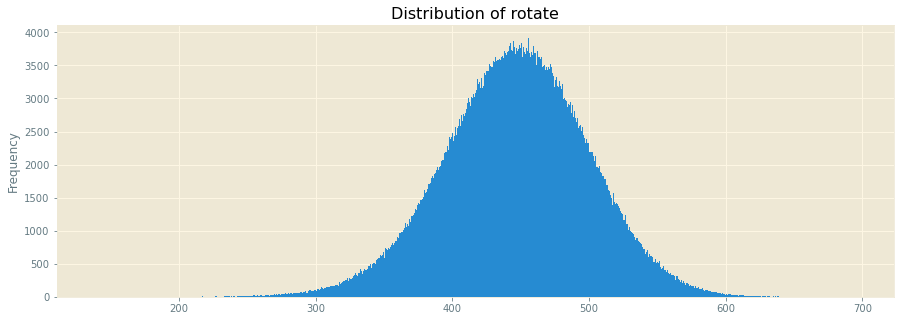

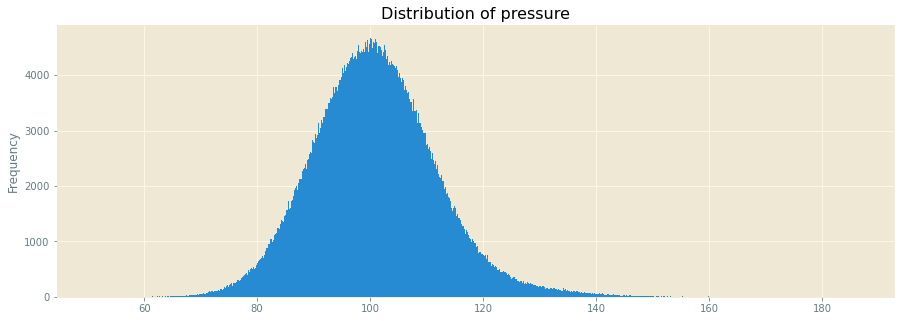

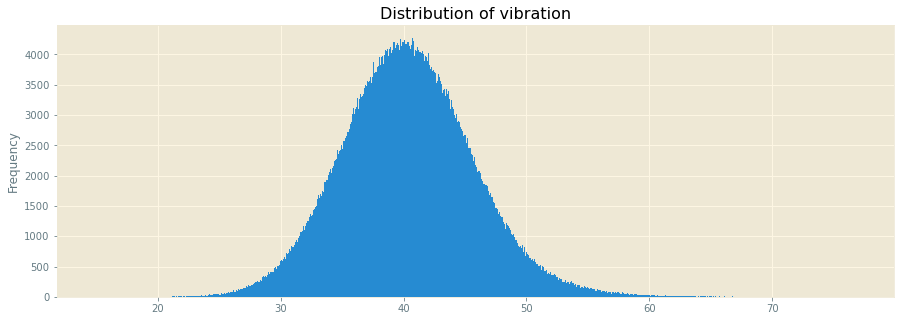

In [27]:
# Check for the distribution of features
for name in ['volt','rotate', 'pressure', 'vibration']:
    plot_hist(telemetry_df, feature_name=name, log=False, bins=1000)

**Summary of Telemetry Data**

* There are no duplicates in the dataset and no duplicates in the machine's timestamp.
* The dataset does not contain any null values and we have confirmed that there are 100 machines.
* The voltage, rotation, pressure and vibration of the machines appear to be normally distributed.


We will repeat the same process for the remaining data sets using the functions we have created and make conclusions.

### Error Data

In [28]:
#Check first few rows
errors_df.head(10)

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
5,2015-01-25 15:00:00,1,error4
6,2015-01-27 04:00:00,1,error1
7,2015-03-03 22:00:00,1,error2
8,2015-03-05 06:00:00,1,error1
9,2015-03-20 18:00:00,1,error1


In [29]:
##Check last few rows
errors_df.tail(10)

,datetime,machineID,errorID
3909,2015-10-24 23:00:00,100,error1
3910,2015-10-27 21:00:00,100,error2
3911,2015-11-05 02:00:00,100,error3
3912,2015-11-07 17:00:00,100,error1
3913,2015-11-12 01:00:00,100,error1
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3
3918,2015-12-22 03:00:00,100,error3


In [30]:
errors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3919 non-null   object
 1   machineID  3919 non-null   int64 
 2   errorID    3919 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.0+ KB


In [31]:
#Check for null values
check_null(errors_df)

datetime     0
machineID    0
errorID      0
dtype: int64

In [32]:
#Check for duplicates
duplicates(errors_df)

0

In [33]:
# check for the different types of errors
errors_df["errorID"].unique()

array(['error1', 'error3', 'error5', 'error4', 'error2'], dtype=object)

In [34]:
#Reset the index to enable plotting 
errors_df.reset_index(inplace=True)

In [35]:
# plotting the bar graphs
def plot_bar(df, feature_name, normalize=True, 
              kind='bar', figsize=(15,5), sort_index=False, title=None, fontsize=None):
    """
    Plot bar for a particular feature
    
    kind : Type of the plot
    
    """
    if sort_index==True:
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_index().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title, fontsize=fontsize)
    else:   
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_values().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title, fontsize=fontsize)
    
    plt.legend()
    plt.show()


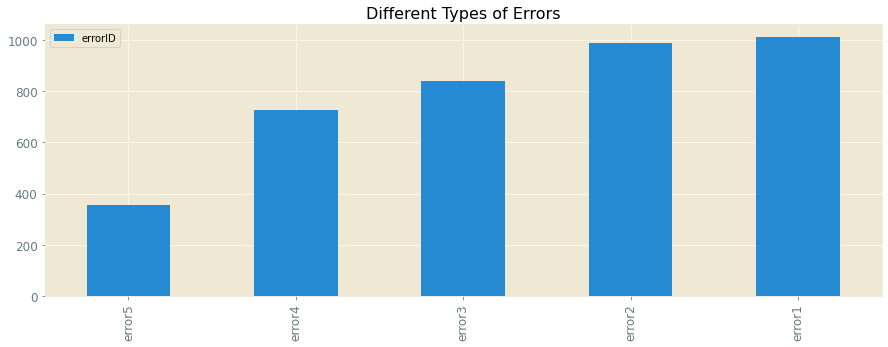

In [36]:
#plot the different types of errors
plot_bar(errors_df, "errorID", normalize=False, title="Different Types of Errors", fontsize=12)

We can check the number of errors distributed across the different machines.

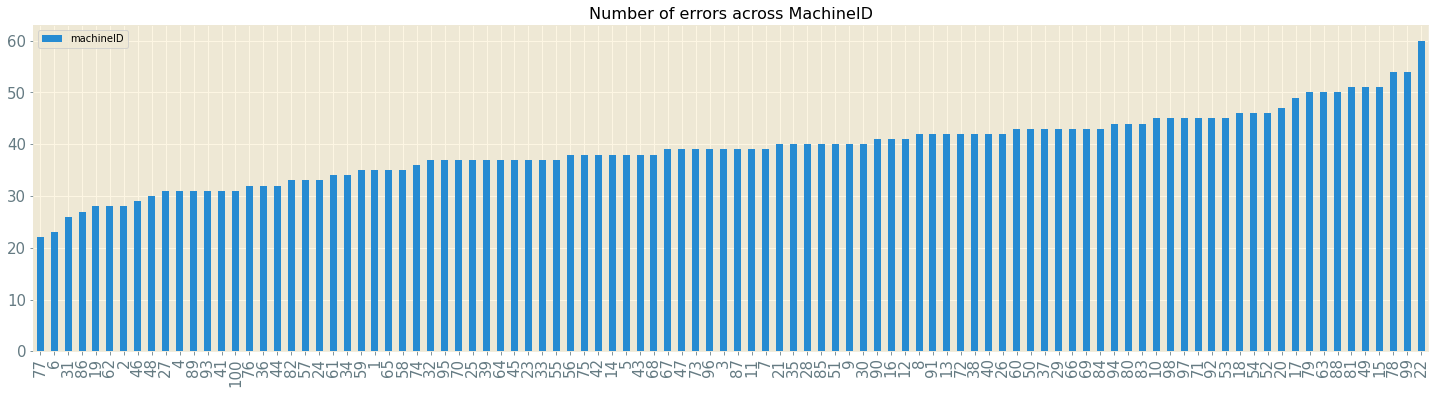

In [37]:
#plotting
plot_bar(errors_df, "machineID", figsize=(25, 6), normalize=False, title="Number of errors across MachineID", fontsize=15)

In [38]:
convert(errors_df)

,index,machineID,errorID
datetime,,,
2015-01-03 07:00:00,0,1,error1
2015-01-03 20:00:00,1,1,error3
2015-01-04 06:00:00,2,1,error5
2015-01-10 15:00:00,3,1,error4
2015-01-22 10:00:00,4,1,error4
...,...,...,...
2015-11-21 08:00:00,3914,100,error2
2015-12-04 02:00:00,3915,100,error1
2015-12-08 06:00:00,3916,100,error2


**Summary for Error data**
* The error data set does not contain any null values or duplicates
* There are 5 different types of errors; error1, error2, error3, error4, error5
* The most common type of error is error1 while the least common type of error is error5
* Machines with ID 22,99 and 78 have the most number of errors.
* Machines with ID 77,6 and 31 have the least number of errors.
* There can be more the 50 errors in a day.


### Maintenance Data


In [39]:
#Check the first few rows
maint_df.head(10)

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4
5,2015-01-05 06:00:00,1,comp1
6,2015-01-20 06:00:00,1,comp3
7,2015-01-20 06:00:00,1,comp1
8,2015-02-04 06:00:00,1,comp4
9,2015-02-04 06:00:00,1,comp3


In [40]:
#Check the last few rows
maint_df.tail(10)

,datetime,machineID,comp
3276,2015-08-11 06:00:00,100,comp3
3277,2015-08-26 06:00:00,100,comp4
3278,2015-09-10 06:00:00,100,comp1
3279,2015-09-25 06:00:00,100,comp1
3280,2015-10-10 06:00:00,100,comp1
3281,2015-10-10 06:00:00,100,comp3
3282,2015-10-25 06:00:00,100,comp4
3283,2015-11-09 06:00:00,100,comp4
3284,2015-12-09 06:00:00,100,comp2
3285,2015-12-24 06:00:00,100,comp2


In [41]:
maint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3286 non-null   object
 1   machineID  3286 non-null   int64 
 2   comp       3286 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.1+ KB


In [42]:
#Check for null values
check_null(maint_df)

datetime     0
machineID    0
comp         0
dtype: int64

In [43]:
#Check for duplicates
duplicates(maint_df)

0

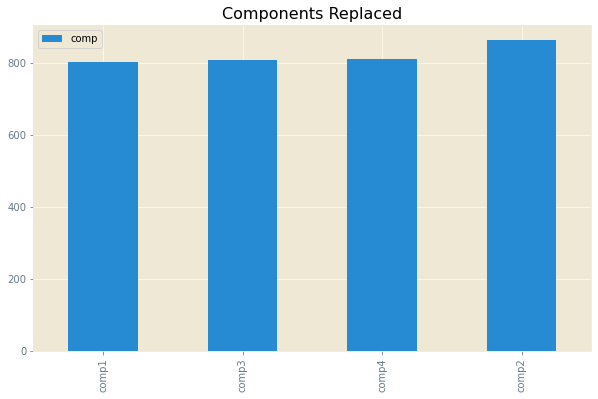

In [44]:
plot_bar(maint_df, 
          feature_name="comp", 
          figsize=(10, 6), 
          normalize=False,
          title="Components Replaced")

**Summary of Maintenance Data**
* The data does not contain any null values or duplicates
* There are four different types of components that are replaced in case of failure
* Component 2 is the most frequently replaced

### Failures Data

In [45]:
# Check first few rows
failures_df.head(10)

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
5,2015-10-17 06:00:00,1,comp2
6,2015-12-16 06:00:00,1,comp4
7,2015-03-19 06:00:00,2,comp1
8,2015-03-19 06:00:00,2,comp2
9,2015-04-18 06:00:00,2,comp2


In [46]:
# Check last few rows
failures_df.tail(10)

,datetime,machineID,failure
751,2015-07-17 06:00:00,99,comp3
752,2015-08-01 06:00:00,99,comp2
753,2015-08-31 06:00:00,99,comp3
754,2015-10-15 06:00:00,99,comp2
755,2015-10-30 06:00:00,99,comp4
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1
760,2015-12-09 06:00:00,100,comp2


In [47]:
# check for null values
check_null(failures_df)

datetime     0
machineID    0
failure      0
dtype: int64

In [48]:
# check for duplicates
duplicates(failures_df)

0

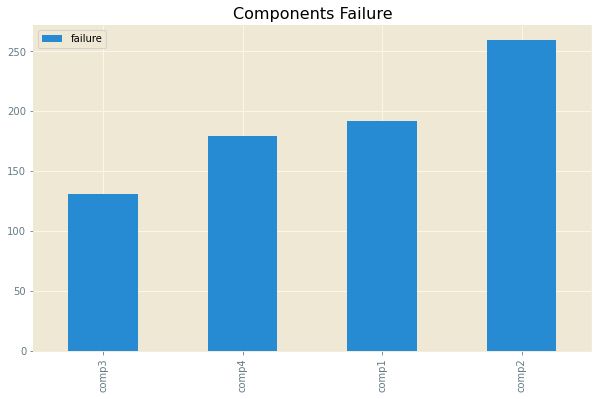

In [49]:
# Plot the number of failures and type of failures
plot_bar(failures_df, 
          feature_name="failure", 
          figsize=(10, 6), 
          normalize=False,
          title="Components Failure")

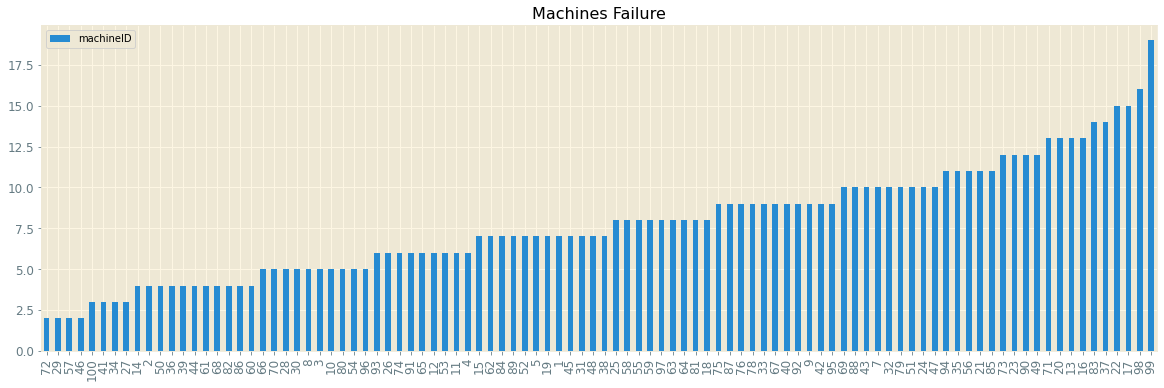

In [50]:
#Plot the machines associated with failure
plot_bar(failures_df, 
          feature_name="machineID", 
          figsize=(20, 6), 
          normalize=False,
          title="Machines Failure",
        fontsize=12)

**Summary of Failure Data**
* The data does not contain any null values or duplicates
* Component 2 is most associated with failure and component 3 is least associated with failure
* Machine 99,98 and 17 have the most number of failures

### Machines Data

In [51]:
# check first few rows
machines_df.head(10)

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2
5,6,model3,7
6,7,model3,20
7,8,model3,16
8,9,model4,7
9,10,model3,10


In [52]:
# check last few rows
machines_df.tail(10)

,machineID,model,age
90,91,model4,17
91,92,model1,2
92,93,model3,18
93,94,model2,18
94,95,model2,18
95,96,model2,10
96,97,model2,14
97,98,model2,20
98,99,model1,14
99,100,model4,5


In [53]:
#Check for null values
check_null(machines_df)

machineID    0
model        0
age          0
dtype: int64

In [54]:
#Check for duplicates
duplicates(machines_df)

0

In [55]:
machines_df.nunique()

machineID    100
model          4
age           20
dtype: int64

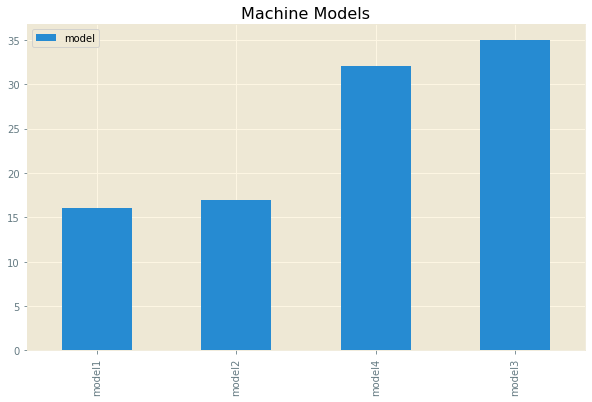

In [56]:
#Plotting model of machines
plot_bar(machines_df, 
          feature_name="model", 
          figsize=(10, 6), 
          normalize=False,
          title="Machine Models")

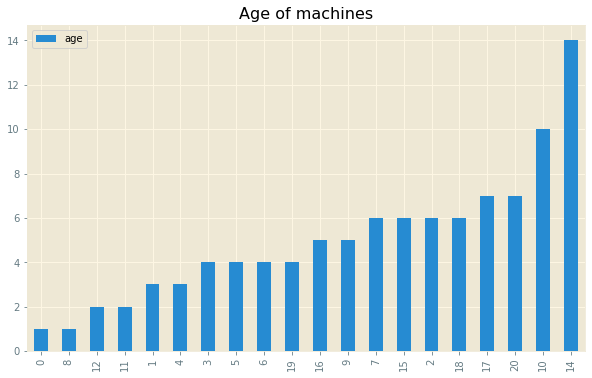

In [57]:
#Plotting age of machines
plot_bar(machines_df, 
          feature_name="age", 
          figsize=(10, 6), 
          normalize=False,
          title="Age of machines")

**Summary of Machine Data**
* The data does not contain any null values or duplicates
* There are 4 different types of machine models.
* The most popular models are model 3 and model 4
* Most machines are 14 years old and 10 years old.

## Data Processing

We will select one machine for this project. We will work with machine 11 since it has appeared among the top in the number of failures and errors.

In [58]:
#Resetting the date index to a normal column
telemetry_df.reset_index(inplace=True)

In [59]:
#Selecting machine 22
machine_slt = telemetry_df.loc[telemetry_df['machineID'] == 11].reset_index(drop=True)
machine_slt.head(n=5)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,11,164.039259,389.699577,113.619975,29.775109
1,2015-01-01 07:00:00,11,180.325510,409.788550,97.506203,40.512160
2,2015-01-01 08:00:00,11,146.917119,420.626012,97.087205,33.420937
3,2015-01-01 09:00:00,11,164.895416,426.409611,86.494413,40.263365
4,2015-01-01 10:00:00,11,174.330072,471.774231,109.277816,39.931749


The error data consists of data about errors that did not result into a machine break down while the failure data represents a record of actual breakdown of machine components. We will check the failure records and error records associated with machine 99. This will help us understand the correlation between the failure and error.
Do errors increase the chances of failure?

In [60]:
# Check failure record of machine 99
fail_slt = failures_df.loc[failures_df['machineID'] == 11]
pd.DataFrame(fail_slt)

,datetime,machineID,failure
58,2015-01-20 06:00:00,11,comp2
59,2015-02-19 06:00:00,11,comp3
60,2015-04-20 06:00:00,11,comp2
61,2015-04-20 06:00:00,11,comp3
62,2015-10-02 06:00:00,11,comp3
63,2015-12-16 06:00:00,11,comp3


In [61]:
# Check error record of machine 99
error_slt = errors_df.loc[errors_df['machineID'] == 11]
pd.DataFrame(error_slt)

,index,machineID,errorID
datetime,,,
2015-01-19 06:00:00,360,11,error2
2015-01-19 06:00:00,361,11,error3
2015-02-15 01:00:00,362,11,error4
2015-02-18 06:00:00,363,11,error4
2015-02-26 23:00:00,364,11,error4
2015-03-20 07:00:00,365,11,error3
2015-04-08 02:00:00,366,11,error1
2015-04-12 12:00:00,367,11,error3
2015-04-15 02:00:00,368,11,error1


In [62]:
# convert(telemetry_df)
# telemetry_df

In [63]:
convert(machine_slt)
machine_slt


,machineID,volt,rotate,pressure,vibration
datetime,,,,,
2015-01-01 06:00:00,11,164.039259,389.699577,113.619975,29.775109
2015-01-01 07:00:00,11,180.325510,409.788550,97.506203,40.512160
2015-01-01 08:00:00,11,146.917119,420.626012,97.087205,33.420937
2015-01-01 09:00:00,11,164.895416,426.409611,86.494413,40.263365
2015-01-01 10:00:00,11,174.330072,471.774231,109.277816,39.931749
...,...,...,...,...,...
2016-01-01 02:00:00,11,196.938166,519.387436,105.389835,35.626335
2016-01-01 03:00:00,11,164.827233,385.385765,117.659936,39.238837
2016-01-01 04:00:00,11,176.453689,442.420761,113.565015,43.272019


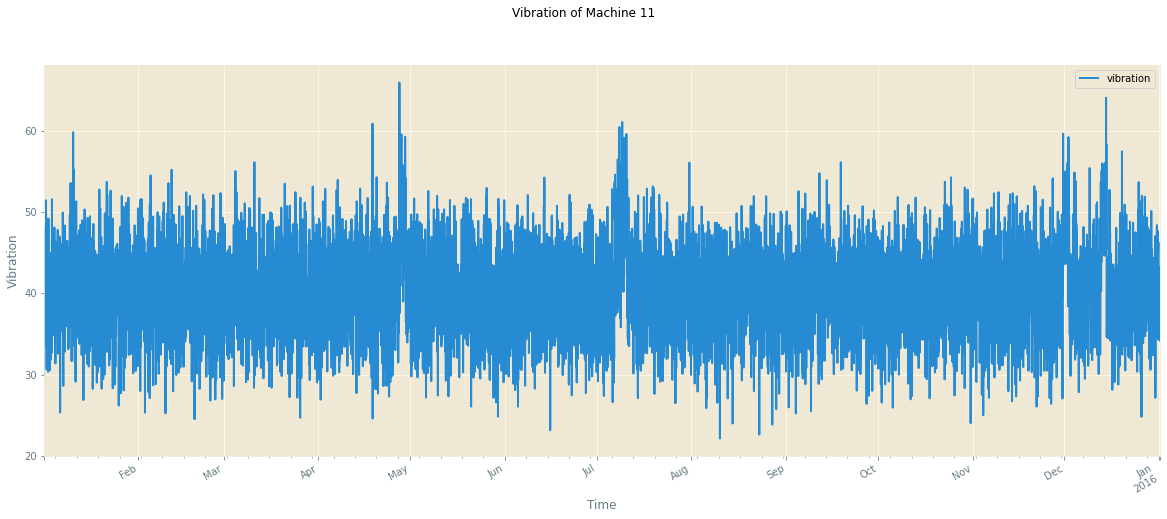

In [64]:
df_vib_machine_11 = machine_slt[
   machine_slt.machineID == 11][["vibration"]]
plot_ts(df_vib_machine_11, title="Vibration of Machine 11", xlabel="Time", ylabel="Vibration")

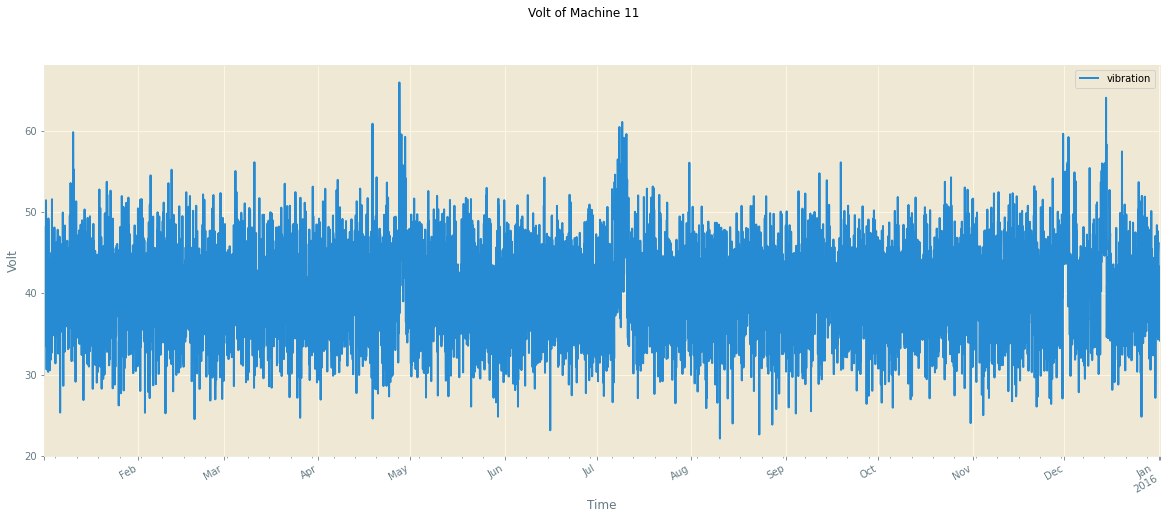

In [65]:
#Plot Volt of Machine 11
df_volt_machine_11 = machine_slt[
    machine_slt.machineID == 11][["volt"]]
plot_ts(df_vib_machine_11, title="Volt of Machine 11", xlabel="Time", ylabel="Volt")

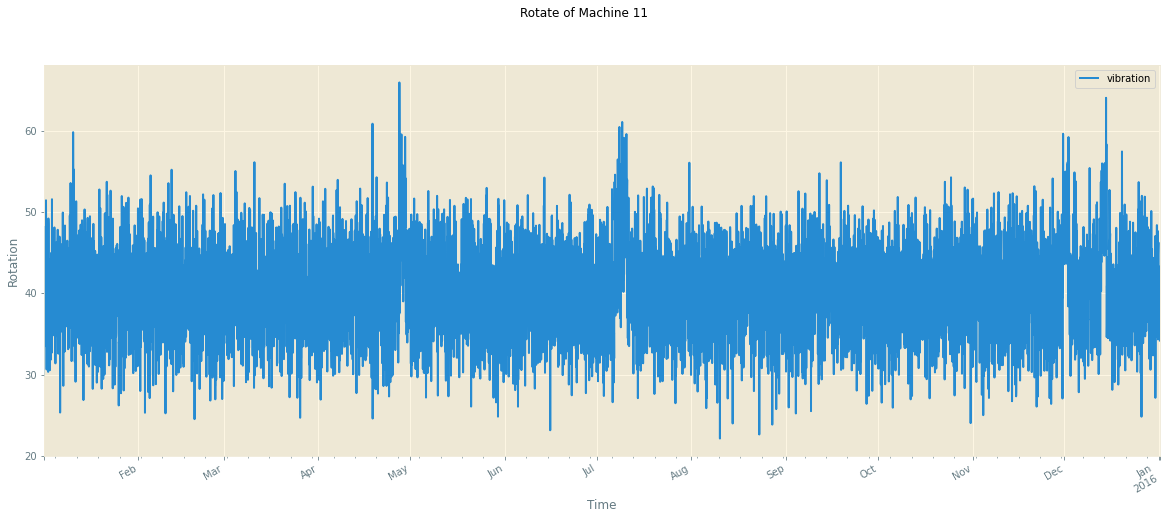

In [66]:
#Plot Rotate of Machine 11
df_rot_machine_11 = machine_slt[
   machine_slt.machineID == 11][["rotate"]]
plot_ts(df_vib_machine_11, title="Rotate of Machine 11", xlabel="Time", ylabel="Rotation")

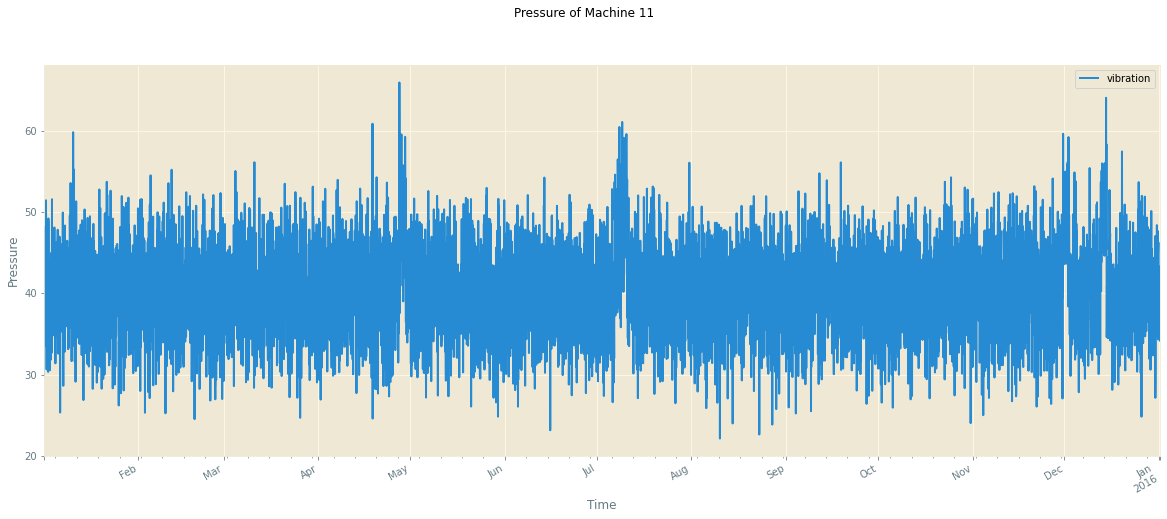

In [67]:
#Plot Pressure of Machine 11
df_press_machine_11 = machine_slt[
    machine_slt.machineID == 11][["pressure"]]
plot_ts(df_vib_machine_11, title="Pressure of Machine 11", xlabel="Time", ylabel="Pressure")

In [68]:
#Resetting index
machine_slt.reset_index(inplace=True)
machine_slt

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,11,164.039259,389.699577,113.619975,29.775109
1,2015-01-01 07:00:00,11,180.325510,409.788550,97.506203,40.512160
2,2015-01-01 08:00:00,11,146.917119,420.626012,97.087205,33.420937
3,2015-01-01 09:00:00,11,164.895416,426.409611,86.494413,40.263365
4,2015-01-01 10:00:00,11,174.330072,471.774231,109.277816,39.931749
...,...,...,...,...,...,...
8756,2016-01-01 02:00:00,11,196.938166,519.387436,105.389835,35.626335
8757,2016-01-01 03:00:00,11,164.827233,385.385765,117.659936,39.238837
8758,2016-01-01 04:00:00,11,176.453689,442.420761,113.565015,43.272019
8759,2016-01-01 05:00:00,11,152.027732,444.685417,92.949722,40.966933


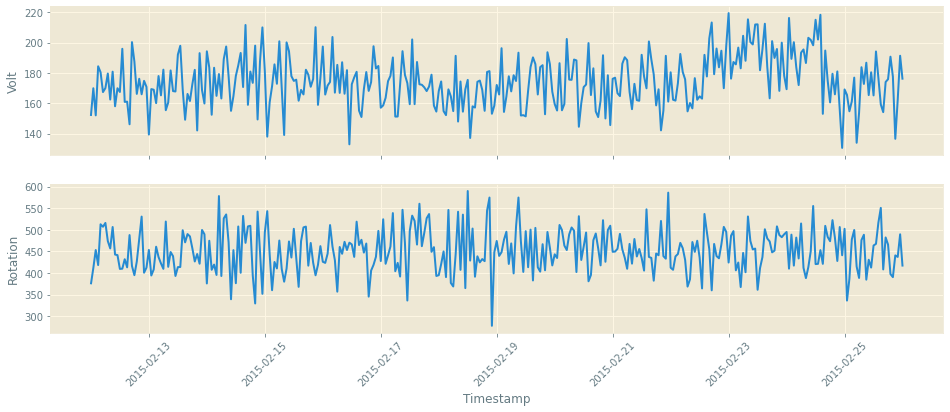

In [69]:

# df_sel.loc[:, 'datetime'] = pd.to_datetime(df_sel.loc[:, 'datetime'])

# Select the date to check from failure records
st = machine_slt.loc[telemetry_df['datetime'] == "2015-02-19"].index.values[0]


# Then, filter the telemetry data by the date and allow 7 days before and after
# the error occurs to observe any abnormalities.
select = machine_slt.loc[st-7*24:st + 7*24,:]
select

# Plot volt and rotation feature
fig, ax = plt.subplots(figsize=(16,6), nrows=2, sharex=True)
ax[0].plot('datetime', 'volt', data=select)
ax[0].set_ylabel("Volt")

ax[1].plot('datetime', 'rotate', data=select)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Rotation")
plt.show()

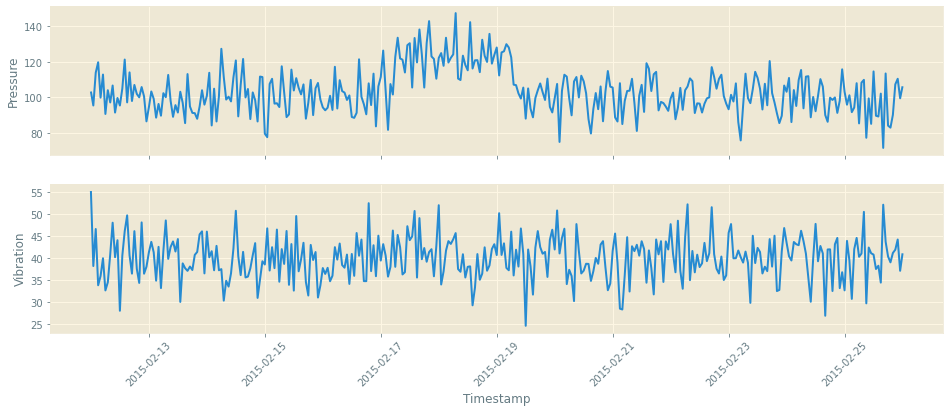

In [70]:
# Plot pressure and vibration feature
fig, ax = plt.subplots(figsize=(16,6),nrows=2, sharex=True)
ax[0].plot('datetime', 'pressure', data=select)
ax[0].set_ylabel("Pressure")

ax[1].plot('datetime', 'vibration', data=select)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Vibration")
plt.show()

on 2015-02-19 there is noticable anomally in the pressure parameter therefore but no anomally in the other parameters, therefore we will use it as our feature target.

### Autocorrelation and partial autocorrelation

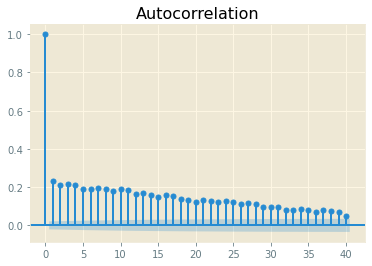

In [71]:
#Check for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation plot
plot_acf(machine_slt['pressure'], lags = 40)
plt.show()

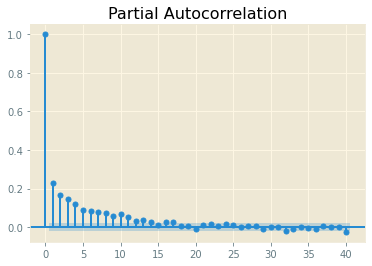

In [72]:
#Check for partial autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# partial autocorrelation plot
plot_pacf(machine_slt['pressure'], lags = 40)
plt.show()

From the autocorrelation plot, there is a positive correlation up to lags of 40, however overall the correlation values are low

From the partial autocorrelation plot, there is a positive correlation up to lags of 15, then low to negative correlation, overall the correlation values are low



## Data Preparation

In this step we will prepare the data for modelling and split it into training and testing data.
We will one hot encode the datetime and normalize the pressure feature.

In [73]:
# Select the date to check from failure records
st_train = machine_slt.loc[machine_slt['datetime'] == "2015-02-19"].index.values[0]

# filter the data to include approximately one month window
start_period = st_train - 14*24
end_period = st_train + 14*24


# create features from the selected machine
def create_feature(start, end):
    pressure = machine_slt.loc[start: end, 'pressure']
    timestamp = machine_slt.loc[start: end, 'datetime']
    timestamp_hour = timestamp.map(lambda x: x.hour)
    timestamp_dow = timestamp.map(lambda x: x.dayofweek)

# apply one-hot encode for timestamp data
    timestamp_hour_onehot = pd.get_dummies(timestamp_hour).to_numpy()

# apply min-max scaler to numerical data
    scaler = MinMaxScaler()
    pressure = scaler.fit_transform(np.array(pressure).reshape(-1,1))

# combine features into one
    feature = np.concatenate([pressure, timestamp_hour_onehot], axis=1)

    X = feature[:-1]
    y = np.array(feature[5:,0]).reshape(-1,1)
    
    return X, y, scaler

X, y, pres_scaler = create_feature(start_period, end_period)

we need to shape the input further into a sequence (3-dimensional numpy array). Create  a function that returns input and output sequence the input sequence consists of 5-points observation, past 5-hour  observations to predict the sensor reading for the next one hour. 

In [74]:
def shape_sequence(arr, step, start):
    out = list()
    for i in range(start, arr.shape[0]):
        low_lim = i
        up_lim = low_lim + step
        out.append(arr[low_lim: up_lim])

        if up_lim == arr.shape[0]:
          # print(i)
          break

    out_seq = np.array(out)
    return out_seq

# Shape the sequence according to the length specified
X_seq = shape_sequence(X, 5, 0)
y_seq = shape_sequence(y, 1, 0)

# Separate the input and output for train and validation
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

print("Training data shape = ", X_train.shape)
print("Validation data shape = ", X_val.shape)

Training data shape =  (534, 5, 25)
Validation data shape =  (134, 5, 25)


## Modelling

We will make use of the Long Short-Term Memory (LSTM) Model. LSTM provides multivariate time series forecasting to predict the future machine breakdown which could be used to improve efficiency and increase remaining useful life (RUL) of the machines.

We will create a simple 2-layer LSTM model

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.losses as loss

#Create a function that returns the model

def create_model(X_train, y_train):
    shape = X_train.shape[1]
    feat_length = X_train.shape[2]

    model = Sequential()
    model.add(LSTM(shape, activation='tanh', input_shape=(shape, feat_length), return_sequences=True))
    model.add(LSTM(shape, activation='tanh', input_shape=(shape, feat_length), return_sequences=False))
    model.add(Dense(shape, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(lr=0.035),
                loss=loss.mean_squared_error)
    model.fit(X_train, y_train, verbose=1, epochs=500)
    
    return model




In [78]:
#Create model
model= create_model(X_train, y_train)

Epoch 1/500
17/17 [==============================] - 0s 11ms/step - loss: 0.0428
Epoch 2/500
17/17 [==============================] - 0s 12ms/step - loss: 0.0227
Epoch 3/500
17/17 [==============================] - 0s 12ms/step - loss: 0.0229
Epoch 4/500
17/17 [==============================] - 0s 16ms/step - loss: 0.0223
Epoch 5/500
17/17 [==============================] - 0s 10ms/step - loss: 0.0216
Epoch 6/500
17/17 [==============================] - 0s 17ms/step - loss: 0.0198
Epoch 7/500
17/17 [==============================] - 0s 9ms/step - loss: 0.0178
Epoch 8/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 9/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0189
Epoch 10/500
17/17 [==============================] - 0s 12ms/step - loss: 0.0170
Epoch 11/500
17/17 [==============================] - 0s 9ms/step - loss: 0.0158
Epoch 12/500
17/17 [==============================] - 0s 9ms/step - loss: 0.0158
Epoch 13/500
17/17 [==========

17/17 [==============================] - 0s 18ms/step - loss: 0.0126
Epoch 102/500
17/17 [==============================] - 0s 12ms/step - loss: 0.0130
Epoch 103/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0121
Epoch 104/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 105/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 106/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0115
Epoch 107/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0116
Epoch 108/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 109/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 110/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0111
Epoch 111/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 112/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0111
Epoch 113/500
17/17 [=======

17/17 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 201/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 202/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 203/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 204/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 205/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 206/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 207/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 208/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0049
Epoch 209/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 210/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 211/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 212/500
17/17 [=========

17/17 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 301/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 302/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 303/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 304/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 305/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 306/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 307/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 308/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 309/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 310/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 311/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0029A: 0s - loss: 0.003
Epoch 312/5

17/17 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 400/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 401/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 402/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 403/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 404/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 405/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 406/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 407/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 408/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 409/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 410/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 411/500
17/17 [=========

17/17 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 500/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0041


We will use the validation data to check the performance of our model.

Validation error =  0.03001502


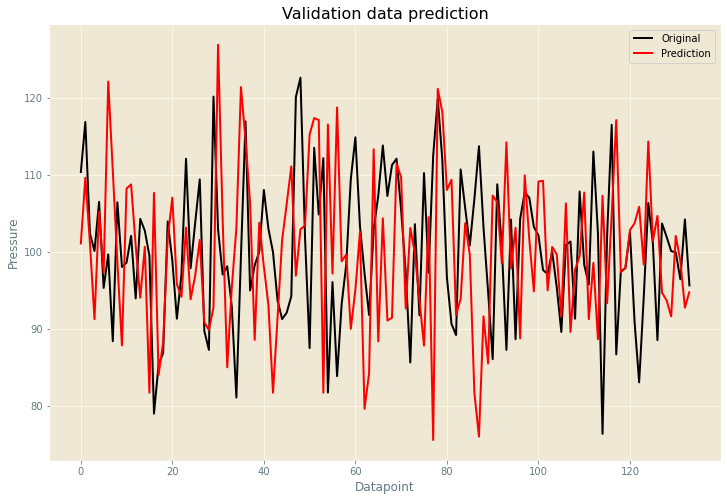

In [84]:
# Predict validation data using the trained model
y_pred = model.predict(X_val)
mse = MeanSquaredError()
val_err = mse(y_val.reshape(-1,1), y_pred)
print("Validation error = ", val_err.numpy())
# Return the value using inverse transform to allow better observation
plt.figure(figsize=(12,8))
plt.plot(pres_scaler.inverse_transform(y_val.reshape(-1,1)), 'k', label='Original')
plt.plot(pres_scaler.inverse_transform(y_pred.reshape(-1,1)), 'r', label='Prediction')
plt.ylabel("Pressure")
plt.xlabel("Datapoint")
plt.title("Validation data prediction")
plt.legend()
plt.show()
     

From the plot we can see that some of the data points don't match completely. This may be a result of the fluctuation between the hours. 
We will compare this with another date where failure occurred 2015-04-20.

Testing error =  0.03940541


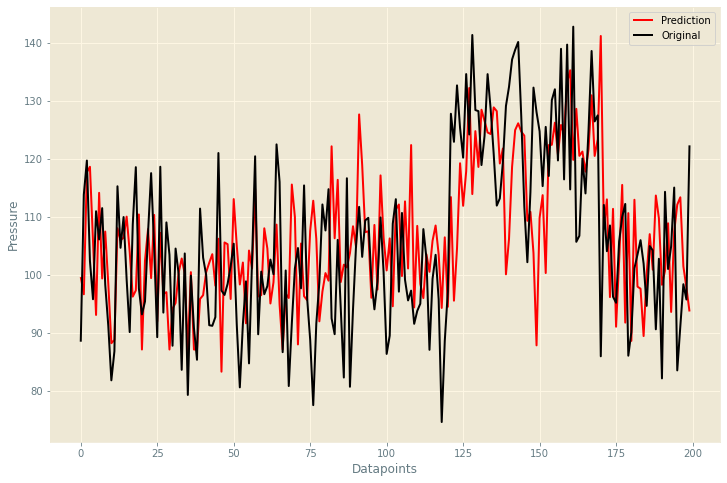

In [87]:
# Select the date where another failure occurred
st_test = machine_slt.loc[machine_slt['datetime'] == "2015-04-20"].index.values[0]

# Then, filter the data to include approximately two-weeks window
start_period_test = st_test - 7*24
end_period_test = st_test + 7*24
X_test, y_test, test_scaler = create_feature(start_period_test, end_period_test)

# Shape the sequence 
X_test_seq = shape_sequence(X_test, 5, 0)
y_test_seq = shape_sequence(y_test, 1, 0)

# Predict the testing data
y_pred_test = model.predict(X_test_seq)
test_err = mse(y_test_seq.reshape(-1,1), y_pred_test)
print("Testing error = ", test_err.numpy())

# Select first 200 datapoints to allow for better plotting
# Return the value using inverse transform to allow better observation
plt.figure(figsize=(12,8))
plt.plot(test_scaler.inverse_transform(y_pred_test[:200].reshape(-1, 1)), 'r', label='Prediction')
plt.plot(test_scaler.inverse_transform(y_test_seq[:200].reshape(-1, 1)), 'k', label='Original')
plt.ylabel("Pressure")
plt.xlabel("Datapoints")
plt.legend()
plt.show()

We can see that the model can predict the sensor reading incase of a machine failure. The testing error is at 0.03 which can further be improved by hypertuning our model.
In our case we have used static data and we have made the predictions for one machine.

## Conclusion
From the model above we can conclude that it is possible to predict a machine failure before actual breakdown. By using IoT, the sensor data can be collected in real-time and we can make real-time predictions for many machines instead of one machine.

This will enable facility managers, electrical engineers and technicians to look into breakdowns before they occur hence saving them on down- time costs.
The project is a work in progress that we intend to work on up to deployment.